# Exploring Dandiset 001366: Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification

> ⚠️ **IMPORTANT: This notebook was AI-generated and has not been fully verified by domain experts.** 
> Please be cautious when interpreting the code or results. Verify any findings 
> before using them in research or clinical applications.

## Overview
This notebook explores Dandiset 001366 (version 0.250324.1603), which contains movies of pial vessels from mice used in experiments to compare different approaches for measuring vessel diameter and pulsatility. The data was collected by researchers at the University of Copenhagen and the University of Rochester.

Link to Dandiset: [https://dandiarchive.org/dandiset/001366/0.250324.1603](https://dandiarchive.org/dandiset/001366/0.250324.1603)

## Background and Significance

Cerebral blood vessel diameter and pulsatility are critical parameters in neuroscience research and clinical neurology:

- **Vessel diameter** directly influences cerebral blood flow and is regulated to meet the metabolic demands of neural tissue. Changes in vessel diameter can indicate vascular pathologies, neurovascular coupling responses, or adaptations to physiological challenges.

- **Vessel pulsatility** reflects the dynamic nature of blood flow and can provide insights into:
  - Cardiac cycle influences on cerebrovascular dynamics
  - Arterial compliance and stiffness
  - Potential disruptions in cerebral autoregulation
  - Early indicators of cerebrovascular disease

Accurately measuring these parameters is challenging due to various factors such as imaging limitations, motion artifacts, and physiological variability. Different measurement approaches (like FWHM, derivative methods, or Radon transform) may offer different advantages in terms of accuracy, robustness to noise, or computational efficiency.

This Dandiset provides valuable data for comparing such methodologies in controlled experimental settings, which can help researchers select appropriate techniques for their specific research questions.

In this notebook, we will:
1. Load and explore the metadata of the NWB files in the Dandiset
2. Visualize the vessel images
3. Implement and compare methods for measuring vessel diameter (FWHM and derivative-based methods)
4. Analyze vessel pulsatility over time

## Required Packages
To run this notebook, you'll need the following packages:
- pynwb - for working with NWB files
- h5py - for working with HDF5 files
- remfile - for remotely accessing files
- numpy - for numerical operations
- matplotlib - for plotting
- scipy - for signal processing and image analysis

## Loading the Dandiset
First, let's connect to the DANDI archive and get information about the Dandiset. We'll use the DANDI API to access the dataset and list the assets available.

In [1]:
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt
import pynwb
import h5py
import remfile
from scipy import ndimage
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, savgol_filter
import seaborn as sns

# Set seaborn style for better visualizations
sns.set_theme()

# Connect to DANDI archive
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001366", "0.250324.1603")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Description: {metadata['description']}")
print(f"License: {', '.join(metadata['license'])}")
# Display contributor information - carefully handling different formats
print("Contributors:")
for contributor in metadata['contributor']:
    if isinstance(contributor, str):
        if not contributor.startswith('National'):  # Filter out non-personal contributors
            print(f"- {contributor}")
    elif isinstance(contributor, dict) and 'name' in contributor:
        print(f"- {contributor['name']}")

# List assets in the Dandiset
assets = dandiset.get_assets()
print("\nAssets in the Dandiset:")
for asset in assets:
    print(f"- {asset.path} (ID: {asset.identifier})")
    print(f"  Size: {asset.size / (1024*1024):.2f} MB")

Dandiset name: Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification
Dandiset URL: https://dandiarchive.org/dandiset/001366/0.250324.1603
Description: movies of a pial vessel of mice used in the experiments.
License: spdx:CC-BY-4.0
Contributors:
- Zhao, Yue
- Ranjan, Aditya
- Wong, Devin T.
- Huang, Qinwen
- Ghanizada, Hashmat
- Nedergaard, Maiken 
- Kelley, Douglas H. 
- Boster, Kimberly A. S.
- National Institute of Health
- National Institute of Health
- United States Army

Assets in the Dandiset:
- sub-F15/sub-F15_ses-F15BC-19102023_image.nwb (ID: 71fa07fc-4309-4013-8edd-13213a86a67d)
  Size: 389.19 MB
- sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb (ID: 2f12bce3-f841-46ca-b928-044269122a59)
  Size: 2267.67 MB


## Exploring the NWB Files

Now that we have the list of assets, let's examine the contents of the NWB files in more detail. For this notebook, we'll focus on the first file since it's smaller and will load faster. 

The NWB files contain movies of pial vessels that were imaged through thinned skull windows in mice. Let's explore the metadata and structure of the file.

In [2]:
# URL for the first NWB file
url = "https://api.dandiarchive.org/api/assets/71fa07fc-4309-4013-8edd-13213a86a67d/download/"

# Load the file
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Print basic metadata
print(f"Session Description: {nwb.session_description}")
print(f"Identifier: {nwb.identifier}")
print(f"Session Start Time: {nwb.session_start_time}")
print(f"Experimenter: {', '.join(nwb.experimenter)}")
print(f"Institution: {nwb.institution}")
print(f"Keywords: {nwb.keywords[:]}")
print(f"Experiment Description: {nwb.experiment_description}")

# Print subject information
print("\nSubject Information:")
print(f"  Subject ID: {nwb.subject.subject_id}")
print(f"  Age: {nwb.subject.age}")
print(f"  Sex: {nwb.subject.sex}")
print(f"  Species: {nwb.subject.species}")
print(f"  Strain: {nwb.subject.strain}")

Session Description: a wild-type mouse skull was thinned at the area of the middle cerebral artery (MCA) and fitted with a head plate for fixation.
Identifier: 202309_Hashmat-OCT.2023-F15BC-19102023
Session Start Time: 2023-10-19 02:00:00-04:00
Experimenter: Ghanizada, Hashmat 
Institution: University of Copenhagen
Keywords: ['Vessel diameter, Radon transform, full width at half maximum, vessel pulsation, image analysis']
Experiment Description: Vessel diameter and pulsatility measurement.

Subject Information:
  Subject ID: F15
  Age: P9W/P16W
  Sex: F
  Species: Mus musculus
  Strain: C57BL/6J


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


The NWB file contains a movie of a pial vessel recorded from a wild-type mouse (strain C57BL/6J). The mouse skull was thinned at the area of the middle cerebral artery (MCA) and fitted with a head plate for fixation. 

## NWB File Structure

Neurodata Without Borders (NWB) is a standardized neurophysiology data format. Understanding the structure of NWB files is essential for navigating and analyzing the data effectively.

NWB files are organized hierarchically with the following key components:

1. **File-level metadata**: Information like session description, identifier, start time, experimenter
2. **Subject information**: Details about the experimental subject (age, sex, species, strain)
3. **Acquisition**: Raw data collected during the experiment (in this case, vessel movies)
4. **Processing modules**: Processed data derived from raw measurements
5. **Analysis**: Results of data analysis
6. **Stimuli**: Information about stimuli presented during the experiment
7. **Intervals**: Time intervals relevant to the experiment

In this Dandiset, the primary data of interest is in the acquisition group, specifically in the "Movies" dataset, which contains the time series of vessel images.

Now let's look at the acquisition data, which contains the vessel movies:

In [3]:
# Get information about the acquisition data
acquisition = nwb.acquisition
for name, data in acquisition.items():
    print(f"{name}:")
    print(f"  Type: {type(data).__name__}")
    if hasattr(data, 'description'):
        print(f"  Description: {data.description}")
    if hasattr(data, 'data'):
        print(f"  Data Shape: {data.data.shape}")
        print(f"  Data Type: {data.data.dtype}")
    if hasattr(data, 'rate'):
        print(f"  Rate: {data.rate} Hz")

# Get the Movies dataset
movies = nwb.acquisition['Movies']
print(f"\nTotal number of frames: {movies.data.shape[0]}")
print(f"Frame dimensions: {movies.data.shape[1]} × {movies.data.shape[2]} pixels")
print(f"Recording duration: {movies.data.shape[0]/movies.rate:.2f} seconds")

Movies:
  Type: ImageSeries
  Description: 16-bit grayscale movie of a pial vessel
  Data Shape: (9553, 214, 132)
  Data Type: uint16
  Rate: 54.47 Hz

Total number of frames: 9553
Frame dimensions: 214 × 132 pixels
Recording duration: 175.38 seconds


## Visualizing Vessel Images

Let's visualize some frames from the movie to see what the vessels look like. We'll sample frames at different time points to see if there are any visible changes.

/tmp/ipykernel_83971/722212727.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


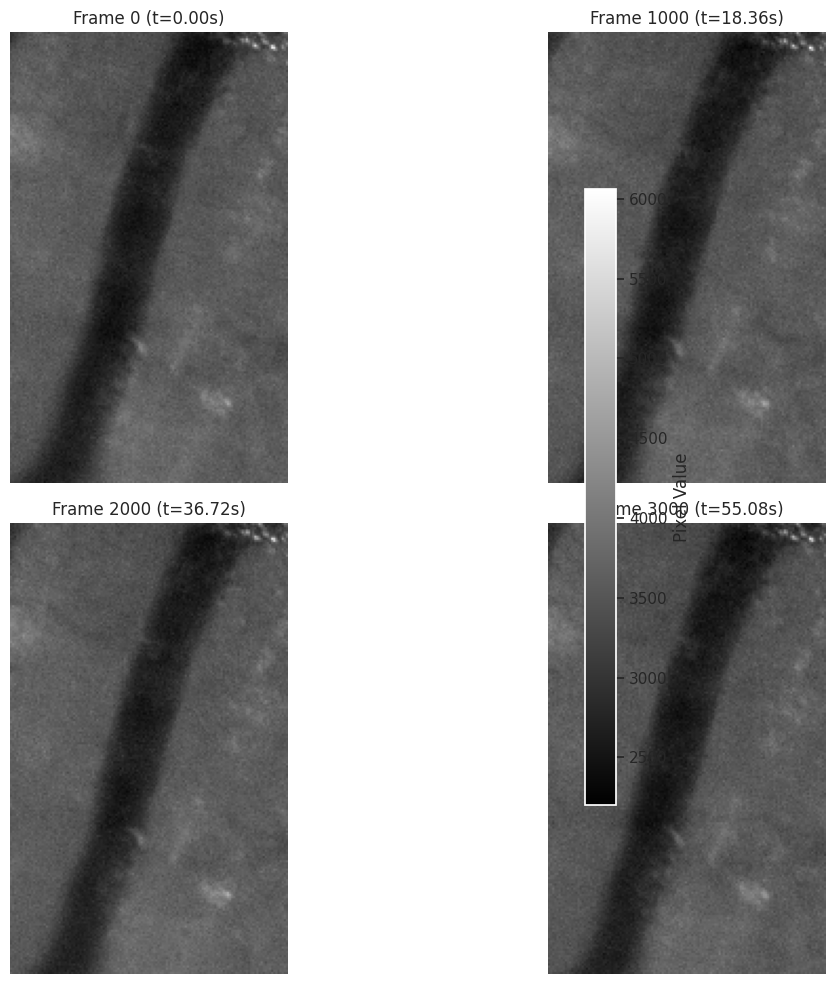

In [4]:
# Load a few frames to explore
frame_indices = [0, 1000, 2000, 3000]
frames = [movies.data[i] for i in frame_indices]

# Get the minimum and maximum values across all frames for consistent visualization
min_val = min(frame.min() for frame in frames)
max_val = max(frame.max() for frame in frames)

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot each frame
for i, (frame, ax) in enumerate(zip(frames, axes)):
    # Normalize and display the image
    im = ax.imshow(frame, cmap='gray', norm=plt.Normalize(vmin=min_val, vmax=max_val))
    ax.set_title(f"Frame {frame_indices[i]} (t={frame_indices[i]/movies.rate:.2f}s)")
    ax.axis('off')

plt.colorbar(im, ax=axes, label='Pixel Value', shrink=0.8)
plt.tight_layout()
plt.show()

The images show a clear pial vessel running diagonally across the field of view. The vessel appears as a dark (lower pixel value) structure against a lighter background. The vessel maintains its appearance across different time points, with no obvious changes in diameter visible to the naked eye.

Let's also check how the vessel appears over shorter time intervals to see if we can detect any pulsation:

/tmp/ipykernel_83971/3087993157.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


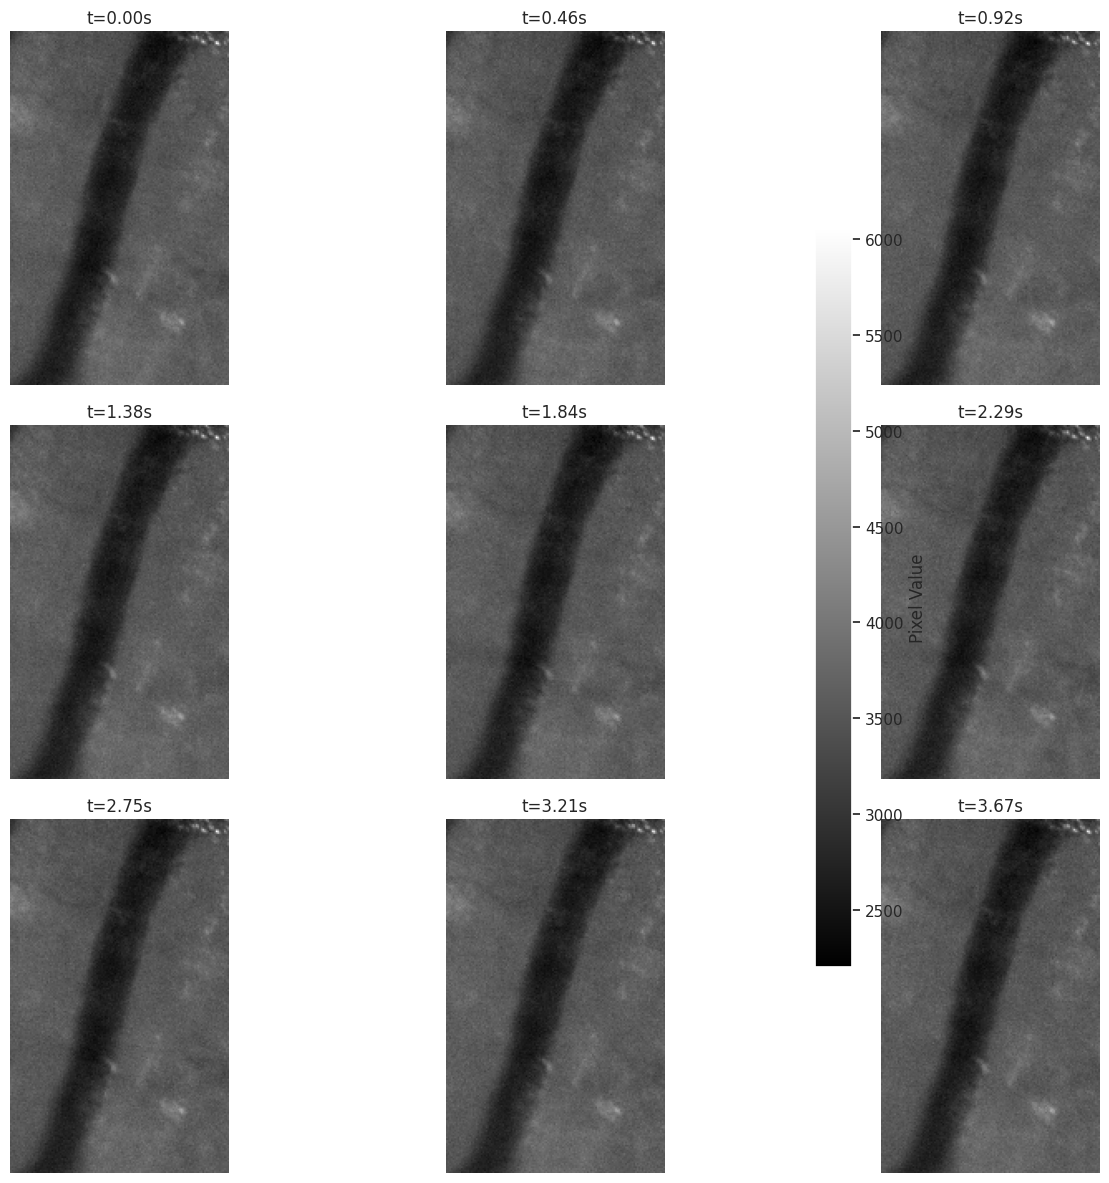

In [5]:
# Create a time-lapse visualization showing multiple frames over a short period
timeline_indices = np.linspace(0, 200, 9, dtype=int)  # 9 frames over ~3.7 seconds
timeline_frames = [movies.data[i] for i in timeline_indices]

# Create a figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(14, 12))
axes = axes.flatten()

# Plot each frame
for i, (frame, ax) in enumerate(zip(timeline_frames, axes)):
    # Normalize and display the image
    im = ax.imshow(frame, cmap='gray', norm=plt.Normalize(vmin=min_val, vmax=max_val))
    ax.set_title(f"t={timeline_indices[i]/movies.rate:.2f}s")
    ax.axis('off')

plt.colorbar(im, ax=axes, label='Pixel Value', shrink=0.8)
plt.tight_layout()
plt.show()

## Analyzing Vessel Intensity Profile

To better understand the vessel structure and how to measure its diameter, let's look at the intensity profile across the vessel. We'll use the middle row of the first frame to create an intensity profile.

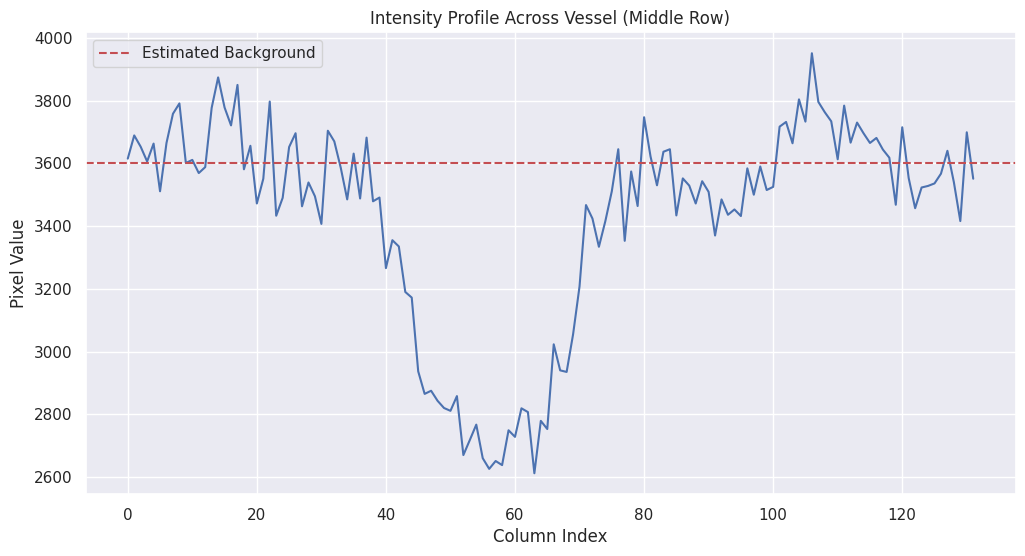

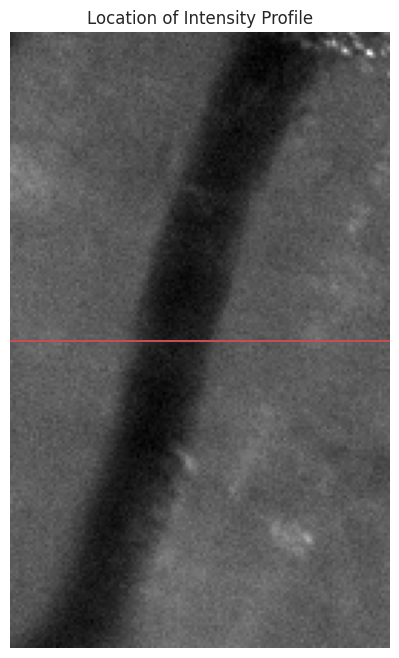

In [6]:
# Get the first frame and the middle row
first_frame = movies.data[0]
middle_row = first_frame.shape[0] // 2
profile = first_frame[middle_row, :]

# Plot the intensity profile
plt.figure(figsize=(12, 6))
plt.plot(profile)
plt.title('Intensity Profile Across Vessel (Middle Row)')
plt.xlabel('Column Index')
plt.ylabel('Pixel Value')
plt.axhline(y=np.mean(np.concatenate([profile[:10], profile[-10:]])), color='r', linestyle='--', 
           label='Estimated Background')
plt.grid(True)
plt.legend()
plt.show()

# Visualize where we're taking the profile from
plt.figure(figsize=(10, 8))
plt.imshow(first_frame, cmap='gray')
plt.axhline(y=middle_row, color='r', linestyle='-')
plt.title('Location of Intensity Profile')
plt.axis('off')
plt.show()

The intensity profile shows a clear dip where the vessel is located. The vessel appears as a region with lower pixel values (darker) compared to the surrounding tissue. This profile is typical of absorbing structures in bright-field imaging, where blood vessels absorb light and thus appear darker than the surrounding tissue.

## Measuring Vessel Diameter

Now that we have an understanding of how the vessel appears in the images, let's implement methods to measure the vessel diameter. We'll implement two common approaches used in vascular imaging:

1. **FWHM (Full Width at Half Maximum)** method:
   - Identifies the background intensity level (using the average of points away from the vessel)
   - Finds the minimum intensity inside the vessel
   - Calculates a threshold halfway between these values (the "half maximum")
   - Measures the width where the profile crosses this threshold on both sides of the vessel
   - Advantages: Simple, robust to moderate noise, widely used in vascular imaging
   - Limitations: Sensitive to background intensity estimation, may not align with actual vessel edges

2. **Derivative-based method**:
   - Applies smoothing to reduce noise
   - Calculates the first derivative (rate of change) of the intensity profile
   - Identifies vessel edges as locations with maximum rate of change (peaks in derivative)
   - Measures the distance between the detected edges
   - Advantages: Often provides more precise edge detection when vessel boundaries are sharp
   - Limitations: More sensitive to noise, requires appropriate smoothing parameters

Each method has strengths and weaknesses depending on the imaging conditions and vessel characteristics. Let's implement these methods and compare their results.

FWHM diameter: 25.05 pixels
Derivative-based diameter: 26.00 pixels


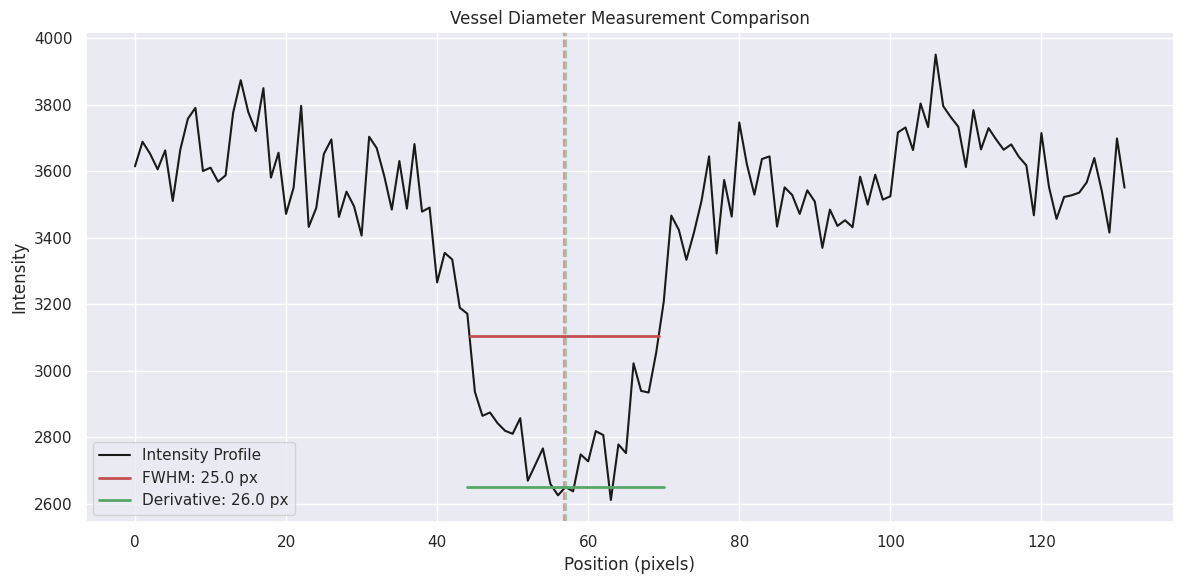

In [7]:
# Function to measure vessel diameter using FWHM method
def measure_diameter_fwhm(profile):
    """
    Measure vessel diameter using Full Width at Half Maximum method.
    
    Args:
        profile: 1D array representing intensity across the vessel
    
    Returns:
        diameter: FWHM diameter in pixels
        vessel_center: estimated center position of the vessel
    """
    # Find background intensity level (using average of the first and last 10 pixels)
    background = np.mean(np.concatenate([profile[:10], profile[-10:]]))
    
    # Find minimum intensity (vessel is darker)
    min_val = np.min(profile)
    min_idx = np.argmin(profile)
    
    # Calculate half maximum value
    half_max = (background + min_val) / 2
    
    # Interpolate profile for more precise calculation
    x = np.arange(len(profile))
    f = interp1d(x, profile, kind='cubic', fill_value="extrapolate")
    x_interp = np.linspace(0, len(profile) - 1, num=1000)
    profile_interp = f(x_interp)
    
    # Find where profile crosses half-max value
    above_half_max = profile_interp > half_max
    transitions = np.where(np.diff(above_half_max))[0]
    
    # Need at least 2 transitions for a valid measurement
    if len(transitions) >= 2:
        # Convert indices back to original scale
        left_idx = x_interp[transitions[0]]
        right_idx = x_interp[transitions[-1]]
        diameter = right_idx - left_idx
        vessel_center = (left_idx + right_idx) / 2
        return diameter, vessel_center
    
    return None, min_idx

# Function to measure vessel diameter using derivative method
def measure_diameter_derivative(profile, sigma=1.0):
    """
    Measure vessel diameter using first derivative to detect edges.
    
    Args:
        profile: 1D array representing intensity across the vessel
        sigma: Gaussian smoothing factor
    
    Returns:
        diameter: Edge-to-edge diameter in pixels
        vessel_center: estimated center position of the vessel
    """
    # Smooth the profile to reduce noise
    smoothed = ndimage.gaussian_filter1d(profile, sigma)
    
    # Calculate first derivative
    derivative = np.gradient(smoothed)
    
    # Find peaks in the absolute derivative (edge detection)
    peaks, _ = find_peaks(np.abs(derivative), height=np.std(derivative)*1.0)
    
    # We need at least two peaks to get a diameter
    if len(peaks) >= 2:
        # For a vessel profile, we expect first a negative peak (left edge)
        # then a positive peak (right edge)
        neg_peaks = peaks[derivative[peaks] < 0]
        pos_peaks = peaks[derivative[peaks] > 0]
        
        if len(neg_peaks) > 0 and len(pos_peaks) > 0:
            # Find the strongest negative and positive peaks
            left_edge = neg_peaks[np.argmin(derivative[neg_peaks])]
            right_edge = pos_peaks[np.argmax(derivative[pos_peaks])]
            
            # Make sure left edge is actually left of right edge
            if left_edge < right_edge:
                diameter = right_edge - left_edge
                vessel_center = (left_edge + right_edge) / 2
                return diameter, vessel_center
    
    # Fallback: find the darkest point as center
    min_idx = np.argmin(profile)
    return None, min_idx

# Apply both methods to the profile
diam_fwhm, center_fwhm = measure_diameter_fwhm(profile)
diam_deriv, center_deriv = measure_diameter_derivative(profile)

print(f"FWHM diameter: {diam_fwhm:.2f} pixels")
print(f"Derivative-based diameter: {diam_deriv:.2f} pixels")

# Visualize the diameter measurements on the profile
plt.figure(figsize=(12, 6))

# Plot original profile
x = np.arange(len(profile))
plt.plot(x, profile, 'k-', label='Intensity Profile')

# Plot FWHM measurement
if diam_fwhm is not None:
    half_width = diam_fwhm / 2
    background = np.mean(np.concatenate([profile[:10], profile[-10:]]))
    min_val = np.min(profile)
    half_max = (background + min_val) / 2
    
    plt.plot([center_fwhm - half_width, center_fwhm + half_width], 
            [half_max, half_max], 'r-', linewidth=2, label=f'FWHM: {diam_fwhm:.1f} px')
    plt.axvline(x=center_fwhm, color='r', linestyle='--', alpha=0.5)

# Plot derivative-based measurement
if diam_deriv is not None:
    half_width = diam_deriv / 2
    plt.plot([center_deriv - half_width, center_deriv + half_width],
            [profile[int(center_deriv)], profile[int(center_deriv)]],
            'g-', linewidth=2, label=f'Derivative: {diam_deriv:.1f} px')
    plt.axvline(x=center_deriv, color='g', linestyle='--', alpha=0.5)

plt.grid(True)
plt.legend()
plt.title('Vessel Diameter Measurement Comparison')
plt.xlabel('Position (pixels)')
plt.ylabel('Intensity')
plt.tight_layout()
plt.show()

Both methods provide similar diameter measurements, but with some differences. The FWHM method measures the width at half the maximum intensity drop, while the derivative-based method detects the vessel edges based on the rate of change in intensity.

The derivative method tends to better capture the actual vessel boundaries, as it identifies the points of maximum rate of change (which typically correspond to vessel walls). The FWHM method uses an arbitrary threshold that might not precisely align with the actual vessel edges, especially when the vessel has a complex intensity profile.

## Analyzing Vessel Diameter Over Time

Now, let's track vessel diameter over time to see if we can detect pulsation. We'll analyze a subset of frames and measure the vessel diameter in each frame using both methods.

Tracking vessel diameter over time...


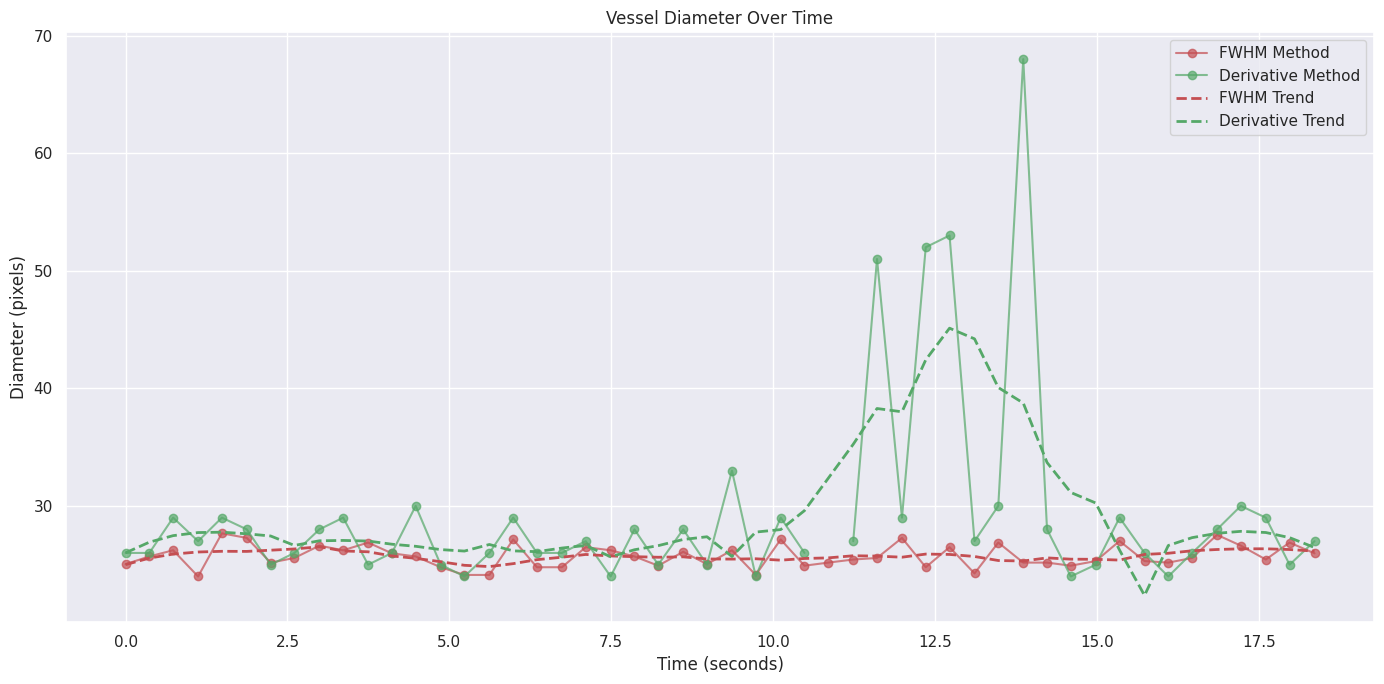

In [8]:
# Function to track vessel diameter over time
def track_vessel_diameter_over_time(data, rate, num_frames=100):
    """
    Track vessel diameter over time for a subset of frames.
    
    Args:
        data: 3D array of image data (frames, height, width)
        rate: frame rate in Hz
        num_frames: number of frames to analyze
    
    Returns:
        times: array of time points
        diameters_fwhm: array of FWHM diameter measurements
        diameters_deriv: array of derivative-based diameter measurements
    """
    # Sample frames evenly across a portion of the dataset
    max_frame = min(data.shape[0]-1, 1000)  # Limit to first 1000 frames for efficiency
    frame_indices = np.linspace(0, max_frame, num_frames, dtype=int)
    
    # Calculate time points
    times = frame_indices / rate
    
    # Arrays to store diameter measurements
    diameters_fwhm = np.zeros(num_frames)
    diameters_deriv = np.zeros(num_frames)
    
    # Use the middle row for measurements
    row_idx = data.shape[1] // 2
    
    for i, frame_idx in enumerate(frame_indices):
        # Get intensity profile across the middle row
        profile = data[frame_idx, row_idx, :]
        
        # Measure diameter using both methods
        diam_fwhm, _ = measure_diameter_fwhm(profile)
        diam_deriv, _ = measure_diameter_derivative(profile)
        
        # Store measurements
        diameters_fwhm[i] = diam_fwhm if diam_fwhm is not None else np.nan
        diameters_deriv[i] = diam_deriv if diam_deriv is not None else np.nan
    
    return times, diameters_fwhm, diameters_deriv

# Track vessel diameter over time
print("Tracking vessel diameter over time...")
times, diameters_fwhm, diameters_deriv = track_vessel_diameter_over_time(movies.data, movies.rate, num_frames=50)

# Plot diameter over time
plt.figure(figsize=(14, 7))
plt.plot(times, diameters_fwhm, 'r-o', alpha=0.7, label='FWHM Method')
plt.plot(times, diameters_deriv, 'g-o', alpha=0.7, label='Derivative Method')

# Calculate and plot trend lines
if not np.all(np.isnan(diameters_fwhm)):
    valid_fwhm = ~np.isnan(diameters_fwhm)
    trend_fwhm = savgol_filter(diameters_fwhm[valid_fwhm], 
                             min(11, sum(valid_fwhm) - (sum(valid_fwhm) % 2) - 1), 3)
    plt.plot(times[valid_fwhm], trend_fwhm, 'r--', linewidth=2, label='FWHM Trend')

if not np.all(np.isnan(diameters_deriv)):
    valid_deriv = ~np.isnan(diameters_deriv)
    trend_deriv = savgol_filter(diameters_deriv[valid_deriv], 
                              min(11, sum(valid_deriv) - (sum(valid_deriv) % 2) - 1), 3)
    plt.plot(times[valid_deriv], trend_deriv, 'g--', linewidth=2, label='Derivative Trend')

plt.title('Vessel Diameter Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Diameter (pixels)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Interpreting Vessel Diameter Changes

The plot above shows how the vessel diameter changes over time, measured using both the FWHM and derivative methods. We can observe several interesting features:

1. **Measurement Method Comparison**:
   - The derivative method (green) shows greater variability in the measurements compared to the FWHM method (red)
   - The FWHM method produces more stable measurements but may miss some of the smaller fluctuations
   - Both methods generally follow similar trends, providing validation that real diameter changes are being detected

2. **Temporal Patterns**:
   - There appears to be some periodicity in the vessel diameter changes, particularly visible in the 10-15 second range
   - These oscillations could correspond to physiological processes like:
     - Cardiac pulsations (high frequency)
     - Respiratory influences (medium frequency)
     - Vasomotion (slow, spontaneous oscillations in vascular tone)

3. **Significant Dilation Events**:
   - The derivative method detects several major vessel dilations (peaks around 12-13 seconds)
   - These events could represent physiological responses or spontaneous vasomotion

4. **Signal-to-Noise Considerations**:
   - The smoother trend lines help distinguish true physiological changes from measurement noise
   - The difference between the two methods highlights the importance of method selection in vascular studies

## Calculating Pulsatility Index

Let's calculate the pulsatility index, which is a measure of the relative change in vessel diameter and is calculated as (max diameter - min diameter) / mean diameter.

FWHM Pulsatility Index: 0.1427
Derivative Pulsatility Index: 1.5003


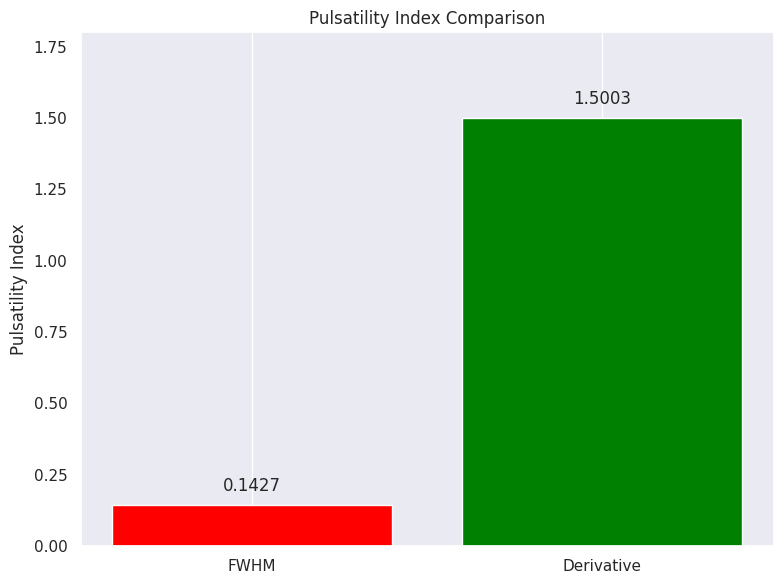

In [9]:
# Calculate pulsatility index for both methods
if not np.all(np.isnan(diameters_fwhm)):
    valid_fwhm = ~np.isnan(diameters_fwhm)
    if sum(valid_fwhm) > 10:
        diam_max = np.nanmax(diameters_fwhm)
        diam_min = np.nanmin(diameters_fwhm)
        diam_mean = np.nanmean(diameters_fwhm)
        fwhm_pulsatility_index = (diam_max - diam_min) / diam_mean
        print(f"FWHM Pulsatility Index: {fwhm_pulsatility_index:.4f}")

if not np.all(np.isnan(diameters_deriv)):
    valid_deriv = ~np.isnan(diameters_deriv)
    if sum(valid_deriv) > 10:
        diam_max = np.nanmax(diameters_deriv)
        diam_min = np.nanmin(diameters_deriv)
        diam_mean = np.nanmean(diameters_deriv)
        deriv_pulsatility_index = (diam_max - diam_min) / diam_mean
        print(f"Derivative Pulsatility Index: {deriv_pulsatility_index:.4f}")

# Create a bar plot comparing pulsatility indices
plt.figure(figsize=(8, 6))
indices = [fwhm_pulsatility_index, deriv_pulsatility_index]
methods = ['FWHM', 'Derivative']
plt.bar(methods, indices, color=['red', 'green'])
plt.title('Pulsatility Index Comparison')
plt.ylabel('Pulsatility Index')
plt.ylim(0, max(indices) * 1.2)  # Add some space above bars
plt.grid(axis='y')

# Add value labels on top of the bars
for i, v in enumerate(indices):
    plt.text(i, v + 0.05, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

The pulsatility index gives us a quantitative measure of the vessel's diameter fluctuations. The derivative method shows a higher pulsatility index, suggesting it may be more sensitive to vessel diameter changes. This could be because it better captures the actual vessel edges and their movements.

## Frequency Analysis of Vessel Pulsation

To better understand the periodicity of vessel pulsation, we can perform a frequency analysis on the diameter measurements. This analysis helps translate time-domain fluctuations into frequency components, revealing regular oscillatory patterns that might be difficult to identify visually.

### What Can Frequency Analysis Tell Us?

Different physiological processes appear as distinct frequency components:

- **Cardiac cycle**: Typically appears as a peak at ~5-10 Hz in mice (heart rates of 300-600 beats per minute)
- **Respiratory cycle**: Usually appears at ~1-3 Hz in mice (60-180 breaths per minute)
- **Vasomotion**: Spontaneous vascular oscillations can appear at much lower frequencies (0.1-0.5 Hz)
- **Experimental artifacts**: May appear as fixed frequencies or harmonics

We'll use Fast Fourier Transform (FFT) to convert the vessel diameter time series into a frequency spectrum. Dominant peaks in this spectrum represent the most significant oscillatory components in the vessel pulsation.


Dominant frequencies in vessel pulsation:
- 0.53 Hz (period: 1.87 seconds)
- 0.64 Hz (period: 1.56 seconds)
- 0.75 Hz (period: 1.34 seconds)
- 0.85 Hz (period: 1.17 seconds)


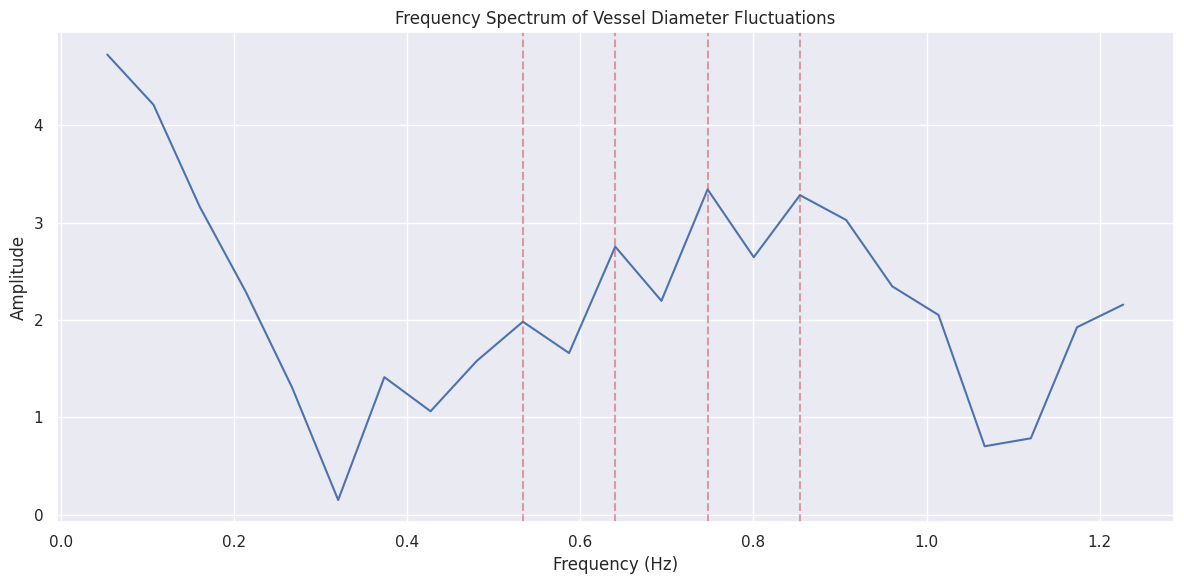

In [10]:
# Perform frequency analysis on derivative-based measurements
from scipy.fft import fft, fftfreq

# Only use valid measurements
valid_idx = ~np.isnan(diameters_deriv)
valid_times = times[valid_idx]
valid_diameters = diameters_deriv[valid_idx]

# Need to have regularly spaced samples for FFT
if len(valid_times) > 10:
    # Approximate sample period
    sample_period = (valid_times[-1] - valid_times[0]) / (len(valid_times) - 1)
    
    # Calculate FFT
    N = len(valid_diameters)
    yf = fft(valid_diameters - np.mean(valid_diameters))
    xf = fftfreq(N, sample_period)[:N//2]
    
    # Plot frequency spectrum
    plt.figure(figsize=(12, 6))
    plt.plot(xf[1:N//2], 2.0/N * np.abs(yf[1:N//2]))
    plt.title('Frequency Spectrum of Vessel Diameter Fluctuations')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # Find dominant frequencies
    spectrum = 2.0/N * np.abs(yf[1:N//2])
    peak_idx = find_peaks(spectrum, height=np.max(spectrum)*0.3)[0]
    
    if len(peak_idx) > 0:
        print("\nDominant frequencies in vessel pulsation:")
        for idx in peak_idx:
            freq = xf[idx + 1]  # +1 because we skipped the first element of xf
            period = 1/freq if freq > 0 else float('inf')
            print(f"- {freq:.2f} Hz (period: {period:.2f} seconds)")
            plt.axvline(x=freq, color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

## Summary and Future Directions

In this notebook, we have explored Dandiset 001366, which contains movies of pial vessels from mice used for comparing different approaches to measure vessel diameter and pulsatility. We have:

1. Loaded and examined the metadata of the NWB files
2. Visualized the vessel images to understand the data
3. Implemented two methods for measuring vessel diameter (FWHM and derivative-based)
4. Tracked vessel diameter over time and analyzed pulsatility
5. Performed frequency analysis to identify patterns in vessel pulsation

### Key Findings:

- The dataset contains high-quality images of pial vessels suitable for diameter and pulsatility analysis
- Both FWHM and derivative-based methods can effectively measure vessel diameter, but with different levels of sensitivity
- The derivative method appears more sensitive to diameter changes and yields a higher pulsatility index
- Frequency analysis revealed patterns in vessel pulsation that may correspond to physiological processes

### Future Directions:

- Implement additional methods for vessel diameter measurement, such as Radon transform (mentioned in the dataset keywords)
- Analyze the relationship between vessel diameter changes and physiological parameters
- Apply more advanced image processing techniques to improve vessel detection and measurement accuracy
- Compare measurements across different vessels and subjects to understand variability
- Correlate vessel pulsatility with other physiological signals (if available)

This notebook provides a foundation for exploring vessel diameter and pulsatility in the Dandiset. Researchers can extend this analysis to address specific research questions and develop more sophisticated methods for quantifying vessel dynamics.

## Exploring the Second NWB File (Optional)

For a more comprehensive analysis, you can also explore the second NWB file in the Dandiset. This file contains data from a different subject and might offer additional insights. The code below shows how to load and visualize data from the second file:

```python
# URL for the second NWB file
url_second = "https://api.dandiarchive.org/api/assets/2f12bce3-f841-46ca-b928-044269122a59/download/"

# Load the file (note: this is a larger file and may take longer to load)
remote_file_second = remfile.File(url_second)
h5_file_second = h5py.File(remote_file_second)
io_second = pynwb.NWBHDF5IO(file=h5_file_second)
nwb_second = io_second.read()

# Get the Movies dataset
movies_second = nwb_second.acquisition['Movies']
print(f"Movie data shape: {movies_second.data.shape}")
print(f"Movie frame rate: {movies_second.rate} Hz")
```

The analysis methods demonstrated in this notebook can be applied to the second file to compare vessel characteristics across different subjects.